# Evaluation of multi-omics GRN inference methods
## Benchmarking of the inferred GRNs
### by Jalil Nourisa

Competition Overview: https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/overview

# Imports

In [1]:

data_type = 'raw' # 'de_train', 'raw'
n_tag = '_n_pearson' #'_n_pearson'  '_n_shifted_algorithm'

import os
import gzip
import pandas as pd
import numpy as np
import anndata as ad
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, LeaveOneGroupOut, KFold
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
import decoupler as dc
import seaborn as sns
import json
import category_encoders as ce
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from scipy.sparse import csr_matrix
from venn import venn

%matplotlib inline

surragate_names = {'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
                   'sp_grn':'Scenic+', 'sp_ct':'Scenic+', 'sp_grn_sign': 'Scenic+-signs',
                   'co_grn':'CellOracle', 'co_ct':'CellOracle', 'co_grn_sign':'CellOracle-signs',
                   'figr_grn':'FigR', 'figr_ct':'FigR', 'figr_grn_sign':'FigR-signs',
                   'baseline':'Baseline',
                   'cov_net': 'Pearson cov',
                   'granie_grn':'GRANIE',
                   'granie_ct':'GRANIE'
                   }


work_dir = '../output'
os.makedirs(f'{work_dir}', exist_ok=True)
colors_light = ['green', '#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray']

train_cell_types = ['T cells CD4+', 'NK cells', 'T regulatory cells', 'T cells CD8+']
train_sm_names = ['Belinostat', 'CHIR-99021', 'Crizotinib', 'Dabrafenib',
       'Dactolisib', 'Foretinib', 'Idelalisib', 'LDN 193189',
       'Linagliptin', 'O-Demethylated Adapalene', 'Palbociclib',
       'Penfluridol', 'Porcn Inhibitor III', 'R428']
test_celltypes = ['B cells', 'Myeloid cells'] 
agg_type = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
cell_types_dummy = ['agg_type', 'NK cells', 'B cells', 'Myeloid cells']
all_cell_types = ['T cells CD4+', 'NK cells', 'T regulatory cells', 'T cells CD8+', 'B cells', 'Myeloid cells']
cell_type_map_agg = {cell_type: 'agg_type' if cell_type in agg_type else cell_type for cell_type in all_cell_types}

controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
control_compound = 'Dimethyl Sulfoxide'

print(data_type)
if data_type == 'de_train':
    # df_train = pd.read_parquet(f'{work_dir}/de_analysis/limma/de_train_t.parquet')
    df_train = pd.read_parquet(f'{work_dir}/de_analysis/edger/voom_lmfit/de_train_t.parquet')
    # df_train = pd.read_parquet(f'{work_dir}/de_analysis/edger/voom_lmfit/de_train_p.parquet')
elif data_type == 'raw':
    bulk_index = ['sm_name', 'cell_type', 'plate_name', 'row']
    bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f{n_tag}.h5ad')
    
    
    bulk_adata_df = pd.DataFrame(bulk_adata.X, columns=bulk_adata.var.gene, index=bulk_adata.obs.index)
    bulk_adata_df = pd.concat([bulk_adata.obs[bulk_index],  bulk_adata_df], axis=1).set_index(bulk_index)
    df_train = bulk_adata_df
else:
    raise ValueError('')
def shuffle_grn(grn):
    grn_s = grn.copy()
    grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
    grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)
    dup_flags = grn_s[['source','target']].duplicated()
    grn_s = grn_s[~dup_flags].reset_index(drop=True)
    if grn_s.duplicated().sum()>0:
        raise ValueError('')
    return grn_s
def sign_grn(grn):
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    return grn_sign


# housekeeping genes
if False:
    df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)

    housekeeping_genes = df.loc[:, 0]  # Gene names
    housekeeping_genes = df_train.columns[df_train.columns.isin(housekeeping_genes)].values
    np.savetxt(f'{work_dir}/benchmark/housekeeping_genes.txt', housekeeping_genes, fmt='%s')
else:
    housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)

print(f'Number of housekeeping genes: {len(housekeeping_genes)}')
df_train.shape

/root/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


raw
Number of housekeeping genes: 3387


(2197, 11930)

# Process inferred GRNs

### Granie

In [486]:
grn_granie = pd.read_csv(f'{work_dir}/infer/granie/grns/all.tsv', sep='\t')
grn_granie = grn_granie[['TF.name', 'peak.ID', 'gene.name', 'TF_gene.r']]
grn_granie.columns = ['source', 'CRE', 'target', 'weight']
granie_ct = grn_granie[['CRE', 'target']].drop_duplicates().reset_index(drop=True)
granie_ct.to_csv(f'{work_dir}/benchmark/CRE_target/granie_ct.csv')

grn_granie = grn_granie.groupby(['source', 'target']).apply(lambda df:df['weight'].mean()).reset_index().rename(columns={0:'weight'})

In [ ]:
grn_granie.to_csv(f'{work_dir}/granie/grns/granie_grn.tsv')

## TF-target links

In [53]:
collectRI = pd.read_csv('../../op_singlecell/input/collectri.csv', index_col=0)
figr_grn = pd.read_csv(f'{work_dir}/infer/figr/grn/grn.csv', index_col=0)
co_grn = pd.read_csv(f'{work_dir}/infer/celloracle/grn/co_grn.csv', index_col=0)
# co_grn_hvg = pd.read_csv(f'{work_dir}/infer/celloracle/grn/co_grn_hvg.csv', index_col=0)
sp_grn = pd.read_csv(f'{work_dir}/infer/scenicplus/grn/grn.csv', index_col=0)
granie_grn = pd.read_csv(f'{work_dir}/infer/granie/grns/granie_grn.tsv', index_col=0)


In [28]:
sp_grn.source.unique().shape

(140,)

In [54]:

grn_models_dict = {"collectRI":collectRI, "co_grn":co_grn, "figr_grn":figr_grn, "sp_grn":sp_grn, 'granie_grn':granie_grn}

# save 
for name, grn_model in grn_models_dict.items():
    print(name)
    grn_model.to_csv(f'{work_dir}/benchmark/grn_models/{name}.csv')


collectRI
co_grn
figr_grn
sp_grn
granie_grn


## Format CRE target connections

In [472]:
# figr
figr_ct = pd.read_csv(f'{work_dir}/infer/figr/peak_gene.csv', index_col=0)[['PeakRanges', 'Gene']]
figr_ct.columns = ['CRE','target']
# co
co_ct = pd.read_csv(f'{work_dir}/infer/celloracle/baseGRN/peak_gene.csv', index_col=0)
co_ct.columns = ['CRE','target']
# cp 
sp_ct = pd.read_csv(f'{work_dir}/infer/scenicplus/grn/grn_extended.csv', index_col=0)[['region', 'target']].drop_duplicates()
sp_ct.columns = ['CRE','target']
# save 
os.makedirs(f'{work_dir}/benchmark/CRE_target', exist_ok=True)
names_ = ["figr_ct", "sp_ct", "co_ct"]
models_ = [figr_ct, sp_ct, co_ct]

for name, model in zip(names_, models_):
    model.to_csv(f'{work_dir}/benchmark/CRE_target/{name}.csv')

## Pearson cov GRN

In [700]:
if False:
    from scipy.stats import spearmanr
    adata_rna = ad.read(f'{work_dir}/scRNA/adata_rna.h5ad')
    adata_rna.X = adata_rna.layers['counts']
    sc.experimental.pp.normalize_pearson_residuals(adata_rna)
    # X_dense = adata_rna.X.todense()
    X_dense = adata_rna.X
    gene_names = adata_rna.var.index.values
    # pearson cov 
    cov_matrix, _ = spearmanr(X_dense)
    # shortlisten 
    top_n = 120000
    array = cov_matrix.flatten()
    array_abs = np.abs(array)
    indices = np.argsort(array_abs)[::-1][:top_n]  # Get indices of top n connections

    row_indices, col_indices = np.unravel_index(indices, cov_matrix.shape)
    top_connections = cov_matrix[row_indices, col_indices]
    # format as df 
    sources = gene_names[row_indices]
    targets = gene_names[col_indices]
    cov_net = pd.DataFrame(dict(source=sources, target=targets, weight=top_connections))
    cov_net = cov_net[~(cov_net.source==cov_net.target)].reset_index(drop=True)

    cov_net.to_csv(f'{work_dir}/benchmark/grn_models/cov_net_pn.csv')


# Topological analysis 

In [2]:
grn_model_names = ["figr_grn", "co_grn", "sp_grn", 'granie_grn']
grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'{work_dir}/benchmark/grn_models/{name}.csv', index_col=0)

grn_models_dict = {surragate_names[name]:grn for name, grn in grn_models_dict.items()}

### Regulatory links

In [475]:
links_n = {name:len(grn) for name, grn in grn_models_dict.items()}
# for cell specific grn models, take the mean
links_n['CellOracle'] = grn_models_dict['CellOracle'].groupby('cell_type').size().mean()
# links_n['co_grn_hvg'] = grn_models_dict['co_grn_hvg'].groupby('cell_type').size().mean()
print(links_n)

{'FigR': 24292, 'CellOracle': 50000.0, 'Scenic+': 33537, 'GRANIE': 10679}


In [476]:
grn_fused_dict = {}
for name, grn in grn_models_dict.items():
    grn['link'] = grn['source']+'_'+grn['target']
    grn_fused_dict[name] = grn['link'].drop_duplicates().reset_index(drop=True)

### Regulatory effect

In [477]:
regulatory_effect_dict = {}
for name, grn in grn_models_dict.items():
    print('-----', name)
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    if name in ['co_grn']:
        celltype_counts = grn_sign.groupby('cell_type').weight.value_counts().to_frame().reset_index()
        signs = [celltype_counts[celltype_counts.weight==1]['count'].mean(), celltype_counts[celltype_counts.weight==-1]['count'].mean()]
    else:
        signs = grn_sign.weight.value_counts().values # 'positive, negative:
    if len(signs)==1:
        signs = [signs[0], 0]
    regulatory_effect_dict[name] = signs
regulatory_effect_dict

----- FigR
----- CellOracle
----- Scenic+
----- GRANIE


{'FigR': array([13952, 10340]),
 'CellOracle': array([126485,  73515]),
 'Scenic+': array([33102,   435]),
 'GRANIE': array([9340, 1339])}

### TFs and target genes

In [479]:
target_genes_dict = {}
tfs_dict = {}
for name, grn in grn_models_dict.items():
    tfs_dict[name] = grn.source.unique() 
    target_genes_dict[name] = grn.target.unique().tolist()

In [481]:
print('number of TFs')
tfs_dict_n =  {key:len(values) for key,values in tfs_dict.items()}
print(tfs_dict_n)
print('number of targets')
target_genes_dict_n = {key:len(values) for key,values in target_genes_dict.items()}
target_genes_dict_n

number of TFs
{'FigR': 389, 'CellOracle': 549, 'Scenic+': 140, 'GRANIE': 180}
number of targets


{'FigR': 7804, 'CellOracle': 8597, 'Scenic+': 10789, 'GRANIE': 6548}

### DORCS

In [487]:
names_ = ["figr_ct", "co_ct", "sp_ct", "granie_ct"]
CRE_target_df_dict = {}
for name in names_:
    model = pd.read_csv(f'{work_dir}/benchmark/CRE_target/{name}.csv', index_col=0)
    model.CRE = model.CRE.str.replace('_','-')
    model.CRE = model.CRE.str.replace(':','-')
    CRE_target_df_dict[name] = model

In [497]:
CRE_target_df_dict = {surragate_names[name]:grn for name, grn in CRE_target_df_dict.items()}

In [498]:
peaks_dict = {}
peaks_n_dict = {}
for name, df in CRE_target_df_dict.items():
    peaks_dict[name] = df.CRE.unique()
    peaks_n_dict[name] = df.CRE.unique().shape[0]


In [499]:
# multiple thresholds 
dorcs_n_dict = {}
thresholds_dorcs = range(5, 20)
for name, df in CRE_target_df_dict.items():
    stack_ = []
    for t in thresholds_dorcs:
        stack_.append((df.groupby('target').size()>=t).sum())
    dorcs_n_dict[name] = stack_

### Master TFs

In [500]:
# range of thresholds 
thresholds_master_TFs = range(100, 5000, 10)
master_tfs_n_dict = {}
for name, grn in grn_models_dict.items():
    stack_ = []
    for t in thresholds_master_TFs:
        size_ = grn.groupby('source').size()
        tfs_n = (size_>=t).sum()
        stack_.append(tfs_n)
    master_tfs_n_dict[name] = stack_

### In-degree for target genes

In [501]:
thresholds_indegree = range(5,20,1)
indegree_n_dict = {}
for name, grn in grn_models_dict.items():
    stack_ = []
    for t in thresholds_indegree:
        size_ = grn.groupby('target').size()
        tfs_n = (size_>=t).sum()
        stack_.append(tfs_n)
    indegree_n_dict[name] = stack_

### Plot number of GRN elements 

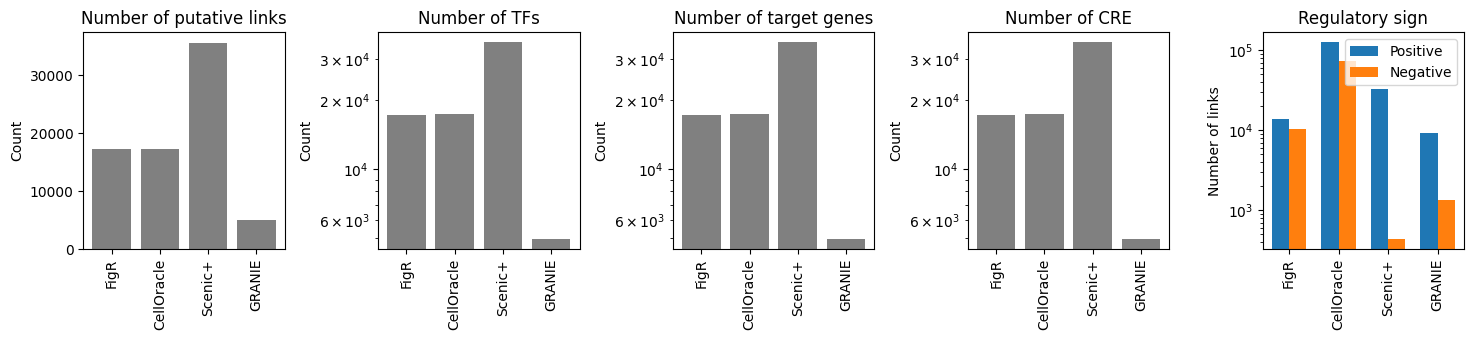

In [502]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3.5)) 
color = 'grey'
## number of links
ax = axes[0]
ax.bar(links_n_.keys(), links_n_.values(), color=color)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of putative links')
# ax.set_yscale('log')

# Rotate category names for better readability
plt.xticks(rotation=45)
## number of TFs
ax = axes[1]
ax.bar(links_n_.keys(), links_n_.values(), color=color)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of TFs')
ax.set_yscale('log')
## number of target 
ax = axes[2]

ax.bar(links_n_.keys(), links_n_.values(), color=color)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of target genes')
ax.set_yscale('log')
plt.tight_layout()

## number of peaks 
ax = axes[3]
ax.bar(links_n_.keys(), links_n_.values(), color=color)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of CRE')
ax.set_yscale('log')
plt.tight_layout()

# regulatory role 
ax = axes[4]
data = regulatory_effect_dict
categories = list(data.keys())
positive_counts = [data[category][0] for category in categories]
negative_counts = [data[category][1] for category in categories]
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
bars1 = ax.bar(x - width/2, positive_counts, width, label='Positive')
bars2 = ax.bar(x + width/2, negative_counts, width, label='Negative')
ax.set_ylabel('Number of links')
ax.set_title('Regulatory sign')
ax.set_xticks(x)
ax.set_xticklabels(categories)
# ax.set_xticklabels([category for category in categories])
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.legend()
fig.savefig(f'{work_dir}/benchmark/figs/stats_regulatory_elements.png', dpi=150, transparent=True)


### Plot intersection of GRN elements
venn diagram

In [503]:
if False:
    # del grn_models_dict['collectRI']
    # del target_genes_dict['collectRI']
    # del tfs_dict['collectRI']

    fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 
    # links
    ax = axes[0]

    # dict_set = {surragate_names[key]:set(item) for key,item in grn_fused_dict.items()}
    dict_set = {key:set(item) for key,item in grn_fused_dict.items()}
    aa = venn(dict_set, hint_hidden=False, fontsize=10, legend_loc=(1,.5), ax=ax)
    aa = ax.set_title('Intersection of putative links',pad=1)
    # TFs 
    ax = axes[1]
    # tfs_dict_set = {surragate_names[key]:set(item) for key,item in tfs_dict.items()}
    tfs_dict_set = {key:set(item) for key,item in tfs_dict.items()}
    aa = venn(tfs_dict_set, hint_hidden=False, 
        figsize=(6, 6), fontsize=10, legend_loc=(.95,.5), ax=ax)
    ax.set_title('Intersection of TFs')
    # targets 
    ax = axes[2]
    # target_genes_set = {surragate_names[key]:set(item) for key,item in target_genes_dict.items()}
    target_genes_set = {key:set(item) for key,item in target_genes_dict.items()}
    aa = venn(target_genes_set, hint_hidden=False, 
        figsize=(6, 6), fontsize=10, legend_loc=(.95,.5), ax=ax)
    ax.set_title('Intersection of target genes')
    plt.tight_layout()

### upsetplot of GRN elements

 ####### Links
 ####### target genes
 ####### TFs
 ####### CRE


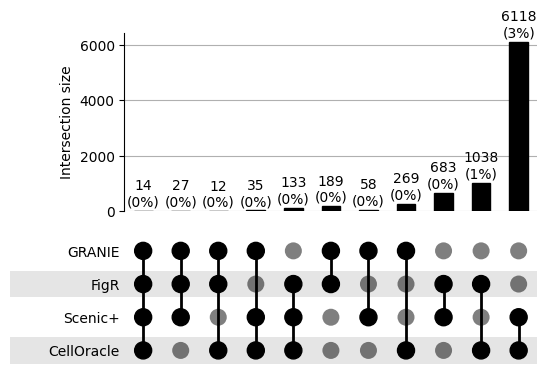

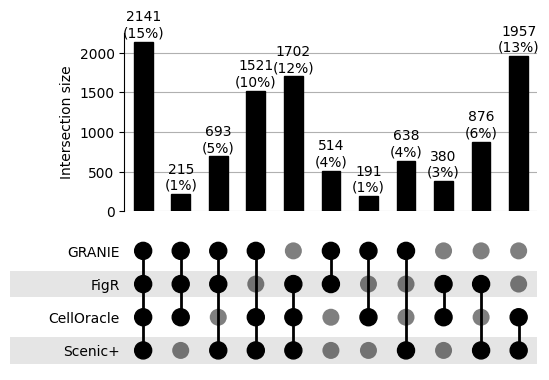

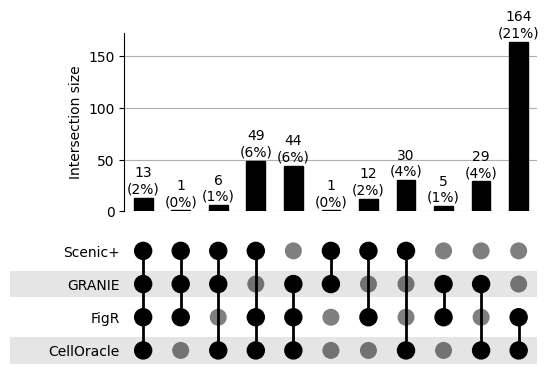

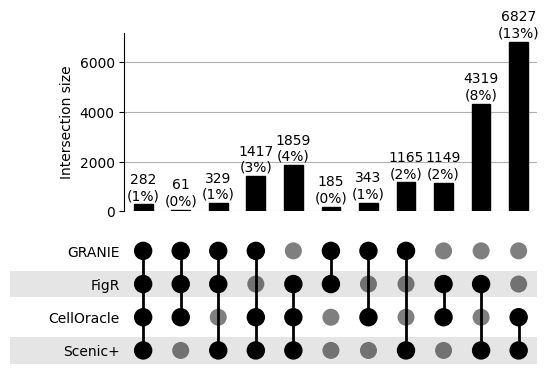

In [504]:
from upsetplot import from_indicators, plot
# Create a set of all unique genes
def convert_df(data):
    all_genes = list(set(gene for genes in data.values() for gene in genes))

    # Initialize DataFrame
    df = pd.DataFrame(index=all_genes)

    # Populate DataFrame
    for key, genes in data.items():
        df[key] = df.index.isin(genes)
    return df

if True:
    print(' ####### Links')
    fig = plt.figure()
    df_interactions = convert_df(grn_fused_dict)    
    out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions),fig=fig, 
            show_counts=True, 
            show_percentages = '{:.0%}',
            sort_by='-degree', 
            # min_subset_size =100, 
            min_degree=2,
            facecolor='black',
            other_dots_color=.5, 
            shading_color =0.1, 
            with_lines = True,
            element_size = 35, #side length
            intersection_plot_elements=5,
            totals_plot_elements = 0)
    matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
    fig.savefig(f'{work_dir}/benchmark/figs/links_interactions.png', dpi=150, transparent=True)

    print(' ####### target genes')
    fig = plt.figure()
    df_interactions = convert_df(target_genes_dict)    
    out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
            show_counts=True, 
            show_percentages = '{:.0%}',
            sort_by='-degree', 
            # min_subset_size =100, 
            min_degree=2,
            facecolor='black',
            other_dots_color=.5, 
            shading_color =0.1, 
            with_lines = True,
            element_size = 35,
            intersection_plot_elements=5,
            totals_plot_elements = 0)
    matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
    fig.savefig(f'{work_dir}/benchmark/figs/targets_interactions.png', dpi=150, transparent=True)

    
    print(' ####### TFs')
    fig = plt.figure()
    df_interactions = convert_df(tfs_dict)
    out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
            show_counts=True, 
            show_percentages = '{:.0%}',
            sort_by='-degree', 
            # min_subset_size =100, 
            min_degree=2,
            facecolor='black',
            other_dots_color=.5, 
            shading_color =0.1, 
            with_lines = True,
            element_size = 35,
            intersection_plot_elements=5,
            totals_plot_elements = 0
            )
    matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
    fig.savefig(f'{work_dir}/benchmark/figs/TFs_interactions.png', dpi=150, transparent=True)

    print(' ####### CRE')
    fig = plt.figure()
    df_interactions = convert_df(peaks_dict)
    out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
            show_counts=True, 
            show_percentages = '{:.0%}',
            sort_by='-degree',  #-cardinality
            # min_subset_size =100, 
            min_degree=2,
            facecolor='black',
            other_dots_color=.5, 
            shading_color =0.1, 
            with_lines = True,
            element_size = 35,
            intersection_plot_elements=5,
            totals_plot_elements = 0
            )
    matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
    fig.savefig(f'{work_dir}/benchmark/figs/CRE_interactions.png', dpi=150, transparent=True)

### Plot connectivity (DORCs, master TFs, etc)

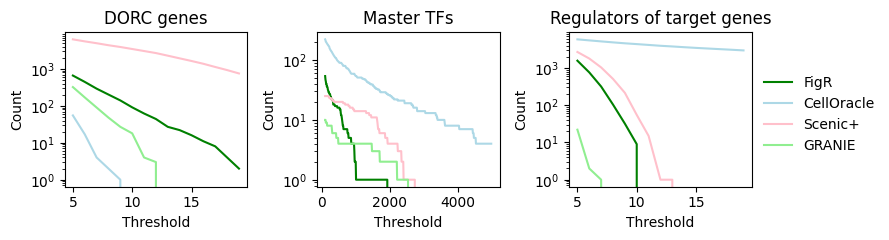

In [506]:
colors_light = ['green', '#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray']

fig, axes = plt.subplots(1, 3, figsize=(9, 2.5)) 
def plot_lines(ax, data, x_range, title):
    for i, key in enumerate(data):
        ax.plot(x_range, data[key], label=key, color=colors_light[i])
        # ax.plot(x_range, data[key], label=key, color=colors_light[i])
    # ax.set_xticks(x_range)
    # ax.set_xticklabels(thresholds_indegree)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_yscale('log')
## DORCs
plot_lines(axes[0], dorcs_n_dict, thresholds_dorcs, 'DORC genes')

## master TFs
plot_lines(axes[1], master_tfs_n_dict, thresholds_master_TFs, 'Master TFs')

## in degree for target genes 
plot_lines(axes[2], indegree_n_dict, thresholds_indegree, 'Regulators of target genes')

axes[-1].legend(loc='upper left', bbox_to_anchor=(1,.8), frameon=False)
plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/connectivity.png', dpi=150, transparent=True)

## Gene and CRE annotation

In [507]:
import pybiomart as pbm
species = 'hsapiens'
host = "http://sep2019.archive.ensembl.org/"   # best one
dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
annot = dataset.query(attributes=['chromosome_name', 'start_position', 'end_position', 'external_gene_name', 'transcript_biotype'])

annot.columns = ['chr', 'start', 'end', 'gene', 'transcript_type']
annot['width'] = annot.end-annot.start

filter = annot['chr'].str.contains('CHR|GL|JH|MT|KI27')
annot = annot[~filter].reset_index(drop=True)
# change in names
# annot.chr = annot.chr.apply(lambda x:f'chr{x}')
# annot.drop_duplicates(inplace=True)

### Annotated genes in df_train

In [508]:
annot_genes = annot.gene.unique()
df_train.columns.isin(annot_genes).sum()/df_train.columns.shape[0]

0.9787906976744186

### Types of target genes

In [509]:
transcript_types = ['lncRNA', 'protein_coding', 'retained_intron']
ratios_stack = []
for grn_name, grn in target_genes_dict.items():
    t_genes = target_genes_dict[grn_name]
    annot_s = annot[annot.gene.isin(t_genes)]
    annot_s = annot_s[annot_s.transcript_type.isin(transcript_types)]
    print('fraction of annotated genes: ', annot_s.gene.unique().shape[0])
    ratios = annot_s.groupby('transcript_type').apply(lambda df:df.gene.unique().size/len(t_genes)).to_dict().values()
    ratios_stack.append([grn_name]+list(ratios))

df_transcript_types = pd.DataFrame(ratios_stack, columns=['grn']+transcript_types).set_index('grn')
df_transcript_types

fraction of annotated genes:  7804
fraction of annotated genes:  8597
fraction of annotated genes:  10789
fraction of annotated genes:  6433


,lncRNA,protein_coding,retained_intron
grn,,,
FigR,0.622886,0.935290,0.517811
CellOracle,0.674305,0.967663,0.610213
Scenic+,0.614237,1.000000,0.585226
GRANIE,0.589646,0.982437,0.579872


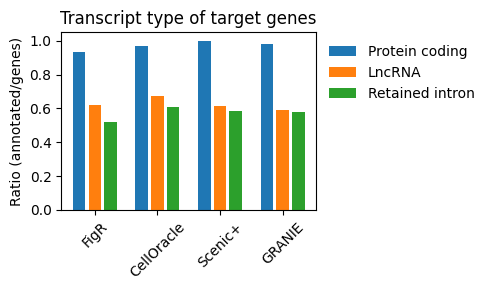

In [511]:

labels = df_transcript_types.index
lncRNA = df_transcript_types.lncRNA
protein_coding = df_transcript_types.protein_coding
retained_intron = df_transcript_types.retained_intron

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
offset = 0.05

# Plotting
fig, ax = plt.subplots(figsize=(5,3))
rects1 = ax.bar(x - width - offset, protein_coding, width, label='Protein coding')
rects2 = ax.bar(x , lncRNA, width, label='LncRNA')
rects3 = ax.bar(x + width + offset, retained_intron, width, label='Retained intron')

# Add labels, title, and legend
ax.set_ylabel('Ratio (annotated/genes)')
ax.set_title('Transcript type of target genes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params('x', rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/transcript_type.png', dpi=150, transparent=True)

### Types of peaks

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
temp_dir = f'{work_dir}/benchmark/temp/peak_annotation/'
for name, grn_ct in CRE_target_df_dict.items():
    peaks = grn_ct.CRE.str.split('-', n=1, expand=True)
    peaks.columns = ['chr','range']
    peaks.to_csv(f'{temp_dir}{name}.txt', index=False)
method_names = list(CRE_target_df_dict.keys())

In [ ]:
%%R -i method_names -i temp_dir
options(digits=5, max.print=100)  # Adjust numbers as needed
set.seed(123)


library(IRanges)
library(GenomicRanges)
library(ggplot2)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

for (name in method_names){
  peaks = read.table(paste0(temp_dir, name, '.txt'), sep=',', header = TRUE)
  peaks = GRanges(peaks$chr, IRanges(peaks$range))
  peaks_annotated = suppressMessages(ChIPseeker::annotatePeak(
      peaks,
      tssRegion = c(-1000, 1000), # extended from -5kb to 5
      TxDb = txdb,
      level = "transcript", 
      assignGenomicAnnotation = TRUE,  # the default
      genomicAnnotationPriority = c("Promoter", "5UTR", "3UTR", "Exon", "Intron",
                                    "Downstream", "Intergenic"),  # the default
      annoDb = NULL,
      sameStrand = FALSE, # the default
      ignoreOverlap = FALSE, # the default
      ignoreUpstream = FALSE, # the default
      ignoreDownstream = FALSE, # the default
      overlap = "TSS", # the default
      verbose = TRUE # the default
    ))
  peaks_annotated_df = as.data.frame(peaks_annotated)
  write.table(peaks_annotated_df, paste0(temp_dir, name, '_annot.txt'), sep=',', row.names = FALSE)
}


>> preparing features information...		 2024-03-27 18:49:22 
>> identifying nearest features...		 2024-03-27 18:49:22 
>> calculating distance from peak to TSS...	 2024-03-27 18:49:22 
>> assigning genomic annotation...		 2024-03-27 18:49:22 
>> assigning chromosome lengths			 2024-03-27 18:49:26 
>> done...					 2024-03-27 18:49:26 
>> preparing features information...		 2024-03-27 18:49:26 
>> identifying nearest features...		 2024-03-27 18:49:26 
>> calculating distance from peak to TSS...	 2024-03-27 18:49:27 
>> assigning genomic annotation...		 2024-03-27 18:49:27 
>> assigning chromosome lengths			 2024-03-27 18:49:30 
>> done...					 2024-03-27 18:49:30 
>> preparing features information...		 2024-03-27 18:49:31 
>> identifying nearest features...		 2024-03-27 18:49:31 
>> calculating distance from peak to TSS...	 2024-03-27 18:49:31 
>> assigning genomic annotation...		 2024-03-27 18:49:31 
>> assigning chromosome lengths			 2024-03-27 18:49:34 
>> done...					 2024-03-27 18:49

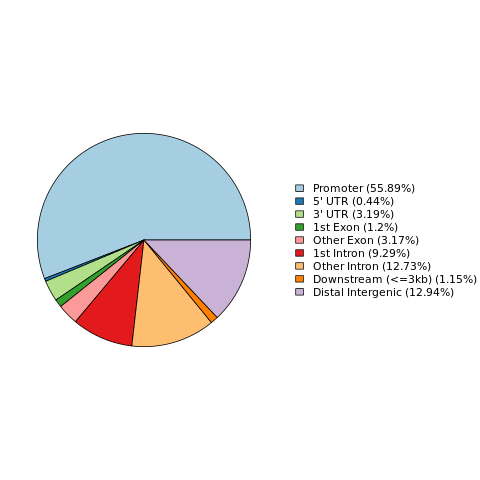

In [ ]:
%%R 
ChIPseeker::plotAnnoPie(peaks_annotated)


In [512]:
map_={'Intron':'Intron', 'Exon':'Exon', 'Promoter':'Promoter', 'Distal':'Distal Intergenic', "3'":"3' UTR", 'Downstream':'Downstream (<=300)', "5'":"5' UTR"}

annotation_dict = {}
for name in method_names:
    ann_df = pd.read_csv(f'{temp_dir}{name}_annot.txt')
    ann = ann_df.annotation.str.split(' ', expand=True)[0]
    ann = ann.map(map_)
    value_counts = ann.value_counts()
    sum_values = value_counts.sum()
    value_ratio = (value_counts/sum_values)*100
    annotation_dict[name] = value_ratio.to_dict()
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
peak_annotation_df.index = peak_annotation_df.index.map(surragate_names)
peak_annotation_df

,Intron,Promoter,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
FigR,35.869375,31.881949,18.342162,6.694220,4.773270,1.629897
CellOracle,0.527868,98.782576,0.271067,0.199734,0.085600,0.009511
Scenic+,26.998659,46.841399,13.565769,6.129465,4.388638,1.222723
GRANIE,22.013844,55.891822,12.942692,4.370573,3.187379,1.150998


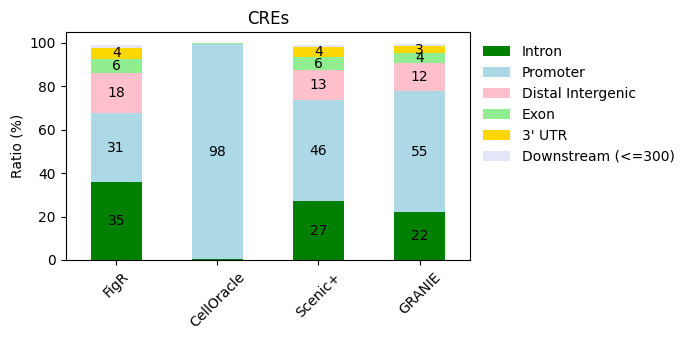

In [513]:
fig, ax = plt.subplots(figsize=(7, 3.5))
ax = peak_annotation_df.plot(kind='bar', stacked=True, ax=ax, rot=45, xlabel='', ylabel='Ratio (%)', color=colors_light)
for c in ax.containers:
    threshold = 2 # skip below this 
    labels = [int(v.get_height().round(2)) if v.get_height() > threshold else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set_title('CREs')
plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/annot_peaks.png', dpi=150, transparent=True)

# HVGs analysis


In [33]:
adata_f = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
adata_pearson = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f_n_pearson.h5ad')
adata_sa = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f_n_shifted_algorithm.h5ad')
n_hvgs = 3000

/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Highly devient genes: raw counts
Germain et al. instead proposes to use deviance for feature selection which works on raw counts [Germain et al., 2020]. Deviance can be computed in closed form and quantifies whether genes show a constant expression profile across cells as these are not informative. Genes with constant expression are described by a multinomial null model, they are approximated by the binomial deviance. Highly informative genes across cells will have a high deviance value which indicates a poor fit by the null model (i.e., they don’t show constant expression across cells).

In [584]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [585]:
# %%R -i work_dir
# library(scry)
# library(zellkonverter)
# library(SingleCellExperiment)

# adata = readH5AD(paste0(work_dir, "/preprocess/bulk_adata_f.h5ad")) # raw counts
# sce = devianceFeatureSelection(adata, assay="X")
# writeH5AD(sce, paste0(work_dir, "/preprocess/adata_sce.h5ad"))

In [8]:
adata_sce = ad.read(f"{work_dir}/preprocess/adata_sce.h5ad")
binomial_deviance  = adata_sce.var['binomial_deviance']
indices = binomial_deviance.argsort()[-n_hvgs:]
mask = np.zeros(adata_sce.var.shape[0], dtype=bool)
mask[indices] = True
hvgs_sce = adata_sce[:, mask].var.gene.values

/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


### Highly variable genes
We calculate HVGs for the normalized data using shifted algorithm and pearson residuals 

In [49]:
if False: 
    sc.pp.highly_variable_genes(adata_pearson_c, n_top_genes=n_hvgs, flavor='seurat')
    hvgs_pearson = adata_pearson_c.var[adata_pearson_c.var.highly_variable].gene.values

    sc.pp.highly_variable_genes(adata_sa, n_top_genes=n_hvgs)
    hvgs_sa = adata_sa.var[adata_sa.var.highly_variable].gene.values
else: # std based
    adata_pearson_c = adata_pearson.copy()
    var_df = adata_pearson_c.var
    var_df['std'] = np.std(adata_pearson_c.X, axis=0)
    hvgs_pearson = var_df.sort_values('std').iloc[-n_hvgs::, :].gene.values

    adata_pearson_c = adata_sa.copy()
    var_df = adata_pearson_c.var
    var_df['std'] = np.std(adata_pearson_c.X, axis=0)
    hvgs_sa = var_df.sort_values('std').iloc[-n_hvgs::, :].gene.values


(11930,)

In [75]:
hvgs_dict = {'PERT-APR':hvgs_pearson, 'PERT-SLA':hvgs_sa, 'SCRY':hvgs_sce}


### Plot std vs sum

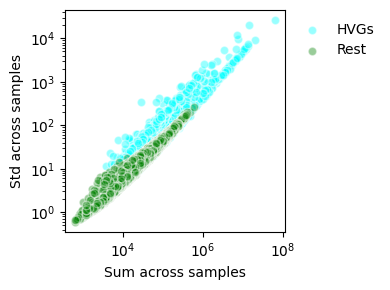

In [82]:
if False:
    adata_stack = [adata_pearson, adata_sa, adata_f]
    

    fig, axes = plt.subplots(1, 3, figsize=(8.5, 3), sharey=False)
    for i, (name, genes) in enumerate(hvgs_dict.items()):
        adata = adata_stack[i]
        var = adata.var
        var['sum'] = adata.X.sum(axis=0)
        var['std'] = adata.X.std(axis=0)
        ax = axes[i]
        mask = var.gene.isin(genes)
        ax.scatter(var['sum'][mask], var['std'][mask], label='HVGs', alpha=0.4, color='cyan', edgecolors='white')
        ax.scatter(var['sum'][~mask], var['std'][~mask], label='Rest', alpha=0.4, color='Green', edgecolors='white')
                
        
        ax.set_xlabel('sum')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(name)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=True)
    axes[0].set_ylabel('Std')
    
    plt.tight_layout()
    fig.savefig(f'{work_dir}/benchmark/figs/hvgs_std_sum.png', dpi=150, transparent=True)
else: # only one set
    genes = hvgs_sce
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)    
    var = adata_f.var
    var['sum'] = adata_f.X.sum(axis=0)
    var['std'] = adata_f.X.std(axis=0)
    mask = var.gene.isin(genes)
    ax.scatter(var['sum'][mask], var['std'][mask], label='HVGs', alpha=0.4, color='cyan', edgecolors='white')
    ax.scatter(var['sum'][~mask], var['std'][~mask], label='Rest', alpha=0.4, color='Green', edgecolors='white')

    
    ax.set_ylabel('Std across samples')
    ax.set_xlabel('Sum across samples')
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    
    plt.tight_layout()
    fig.savefig(f'{work_dir}/benchmark/figs/hvgs_sum_std.png', dpi=150, transparent=True)



In [83]:
if False:
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), sharey=False)
    hvgs_dict_set = {key:set(genes) for key, genes in hvgs_dict.items()}
    
    aa = venn(hvgs_dict_set, hint_hidden=False, fontsize=10, legend_loc=(.75,.15), ax=ax)
    # ax.set_title('Intersection of HVGs',pad=1)
    # ax.legend()
    plt.tight_layout()
    fig.savefig(f'{work_dir}/benchmark/figs/hvgs_intersection.png', dpi=150, transparent=True)
    plt.show()

### GRN targets vs HVGs 

In [13]:
genesets_dict = {**{name:grn.target.unique() for name, grn in grn_models_dict.items()}, **{'HKGs':housekeeping_genes}}

In [85]:
hvgs = hvgs_sce

hvgs_intersection_n_dict = {}
hvgs_intersection_ratio_dict = {}
top_p_dict = {}
n_random = 100
for name, geneset in genesets_dict.items():
    pert_genes = df_train.columns
    shared_genes = np.intersect1d(geneset, pert_genes)
    shared_hvgs_n = len(np.intersect1d(hvgs, shared_genes))
    shared_hvgs_ratio = shared_hvgs_n/len(shared_genes)

    hvgs_intersection_n_dict[name] = shared_hvgs_n
    hvgs_intersection_ratio_dict[name] = shared_hvgs_ratio

    # to percentile
    random_ratios = []
    for i in range(n_random):
        random_genes = np.random.choice(pert_genes, shared_hvgs_n)
        random_ratios.append(len(np.intersect1d(hvgs, random_genes))/shared_hvgs_n)
    top_p = (np.asarray(random_ratios)>shared_hvgs_ratio).sum()/n_random
    top_p_dict[name] = top_p
hvgs_intersection_ratio_dict

{'FigR': 0.3550125072157014,
 'CellOracle': 0.32820643193085036,
 'Scenic+': 0.3098992294013041,
 'GRANIE': 0.32252735907495356,
 'HKGs': 0.20283436669619131}

In [86]:
top_p_dict

{'FigR': 0.0, 'CellOracle': 0.0, 'Scenic+': 0.0, 'GRANIE': 0.0, 'HKGs': 1.0}

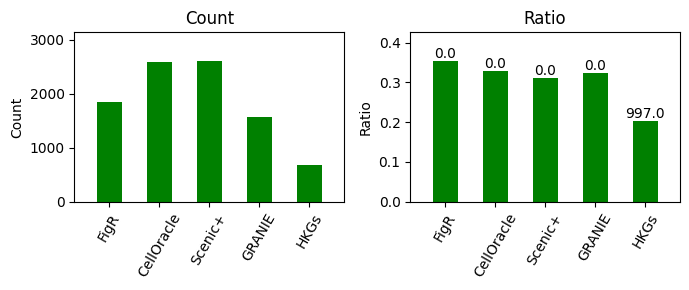

In [102]:
hvgs = hvgs_sce

fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=False)
hvgs_intersection_n_dict = {}
hvgs_intersection_ratio_dict = {}
top_p_dict = {}
for name, geneset in genesets_dict.items():
    pert_genes = df_train.columns
    shared_genes = np.intersect1d(geneset, pert_genes)
    shared_hvgs_n = len(np.intersect1d(hvgs, shared_genes))
    shared_hvgs_ratio = shared_hvgs_n/len(shared_genes)

    hvgs_intersection_n_dict[name] = shared_hvgs_n
    hvgs_intersection_ratio_dict[name] = shared_hvgs_ratio

    # to percentile
    random_ratios = []
    for _ in range(1000):
        random_genes = np.random.choice(pert_genes, shared_hvgs_n)
        random_ratios.append(len(np.intersect1d(hvgs, random_genes))/shared_hvgs_n)
    top_p = (np.asarray(random_ratios)>shared_hvgs_ratio).sum()/1000
    top_p_dict[name] = top_p

def plot_bar(ax, data, y_label, title, top_p_dict=None):
    x_range = [x for x in range(len(data))]
    y_values = list(data.values())
    ax.bar(x_range, y_values, width=width, color=colors_light[0], label=hvg_name)
    ax.set_xticks(x_range)
    ax.set_xticklabels(data.keys())
    ax.tick_params(axis='x', rotation=60)
    ax.set_title(title)
    ax.margins(x=.1, y=.2)
    ax.set_ylabel(y_label)
    if top_p_dict is None:
        return 
    for i_text, value in enumerate(top_p_dict.values()):
        # if value < 0.0001:
        #     txt = '***'
        # if value < 0.001:
        #     txt = '**'
        # elif value < 0.01:
        #     txt = '*'
        # else:
        #     txt = ''
        txt = f'{value*1000}'
        ax.text(x_range[i_text], y_values[i_text], txt, ha='center', va='bottom')

width = .5

plot_bar(axes[0], hvgs_intersection_n_dict, y_label='Count', title='Count')
plot_bar(axes[1], hvgs_intersection_ratio_dict, y_label='Ratio', title='Ratio', top_p_dict=top_p_dict)

# axes[1].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=True)

plt.tight_layout()
plt.show()
fig.savefig(f'{work_dir}/benchmark/figs/hvgs_stats.png', dpi=150, transparent=True)

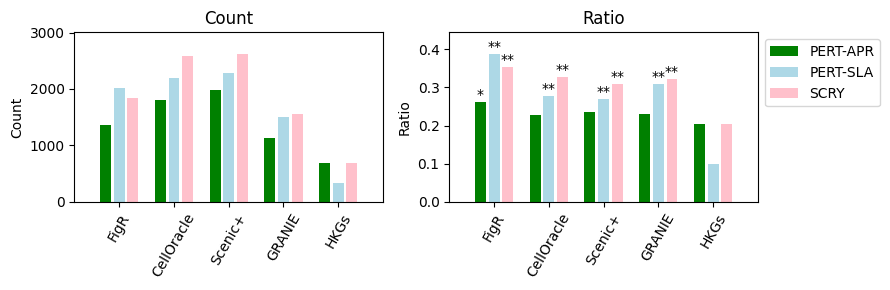

In [26]:
if False:
    fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=False)

    for i, (hvg_name, hvgs) in enumerate(hvgs_dict.items()):
        hvgs_intersection_n_dict = {}
        hvgs_intersection_ratio_dict = {}
        top_p_dict = {}
        for name, geneset in genesets_dict.items():
            pert_genes = df_train.columns
            shared_genes = np.intersect1d(geneset, pert_genes)
            shared_hvgs_n = len(np.intersect1d(hvgs, shared_genes))
            shared_hvgs_ratio = shared_hvgs_n/len(shared_genes)

            hvgs_intersection_n_dict[name] = shared_hvgs_n
            hvgs_intersection_ratio_dict[name] = shared_hvgs_ratio

            # to percentile
            random_ratios = []
            for _ in range(1000):
                random_genes = np.random.choice(pert_genes, shared_hvgs_n)
                random_ratios.append(len(np.intersect1d(hvgs, random_genes))/shared_hvgs_n)
            top_p = (np.asarray(random_ratios)>shared_hvgs_ratio).sum()/1000
            top_p_dict[name] = top_p

        def plot_bar(ax, data, y_label, title, top_p_dict=None):
            x_range = [x + ((i-1)*offset) for x in range(len(data))]
            y_values = list(data.values())
            ax.bar(x_range, y_values, width=width, color=colors_light[i], label=hvg_name)
            ax.set_xticks(range(len(data)))
            ax.set_xticklabels(data.keys())
            ax.tick_params(axis='x', rotation=60)
            ax.set_title(title)
            ax.margins(x=.1, y=.15)
            ax.set_ylabel(y_label)
            if top_p_dict is None:
                return 
            for i_text, value in enumerate(top_p_dict.values()):
                if value < 0.001:
                    txt = '**'
                elif value < 0.05:
                    txt = '*'
                else:
                    txt = ''
                ax.text(x_range[i_text], y_values[i_text], txt, ha='center', va='bottom')
        
        width = .2
        offset = .25

        plot_bar(axes[0], hvgs_intersection_n_dict, y_label='Count', title='Count')
        plot_bar(axes[1], hvgs_intersection_ratio_dict, y_label='Ratio', title='Ratio', top_p_dict=top_p_dict)

    axes[1].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=True)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'{work_dir}/benchmark/figs/hvgs_stats.png', dpi=150, transparent=True)

<Figure size 640x480 with 0 Axes>

## Plot all

In [ ]:
ratio_genes_dict = {}
for name, grn in grn_models_dict.items():
    genes = grn.target.unique()
    ratio = len(np.intersect1d(df_train.columns, genes))/df_train.columns.shape[0]
    ratio_genes_dict[name] = ratio


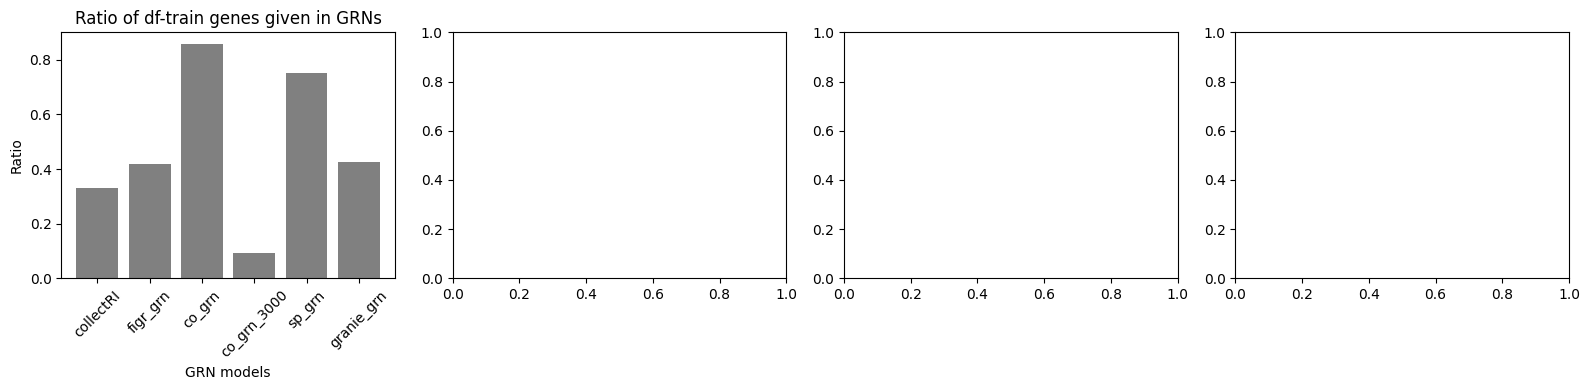

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4)) 
# fraction of genes 
ax = axes[0]
# links_n_ = {surragate_names[key]:value for key,value in ratio_genes_dict.items()}
links_n_ = {key:value for key,value in ratio_genes_dict.items()}
ax.bar(links_n_.keys(), links_n_.values(), color=color)
ax.set_xlabel('GRN models')
ax.set_ylabel('Ratio')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Ratio of df-train genes given in GRNs')

plt.tight_layout()

# Multivariate 

In [103]:
grn_model_names = ["collectRI", "figr_grn", "co_grn", "sp_grn", "granie_grn"]
grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'{work_dir}/benchmark/grn_models/{name}.csv', index_col=0)

In [104]:
mean_tfs_n = 800
genes_n = df_train.columns.shape[0]
sparsity = 0.99
X_random = np.random.choice([0, -1, 1], size=(genes_n, mean_tfs_n), p=[sparsity, (1-sparsity)/2, (1-sparsity)/2])
row_names = df_train.columns
col_names = [f'TF_{i}' for i in range(mean_tfs_n)]
grn_random = pd.DataFrame(X_random, index=row_names, columns=col_names)
grn_random.reset_index(inplace=True)
grn_random = pd.melt(grn_random, id_vars=['index'], var_name='TF', value_name='weight')
grn_random.columns = ['target', 'source', 'weight']
grn_random = grn_random[grn_random.weight!=0].reset_index(drop=True)
# grn_models_dict['grn_random'] = grn_random


In [105]:
import lightgbm
from sklearn.ensemble import GradientBoostingRegressor

class lightgbm_wrapper:
    def __init__(self, params):
        self.params =  params
        
    def fit_predict(self, X_train, Y_train, X_test):
        y_pred_list = []
        for i in range(Y_train.shape[1]):
            regr = lightgbm.LGBMRegressor(**self.params)
            regr.fit(X_train, Y_train[:, i])
            y_pred = regr.predict(X_test)
            y_pred_list.append(y_pred)
            
        return np.stack(y_pred_list, axis=1)

In [221]:
x = np.array([[.1,.2], [-.1, -2]])
x[x>0]=1
x[x<0]=-1
x

array([[ 1.,  1.],
       [-1., -1.]])

In [225]:
reg_type = 'ridge'
manipulate = 'shuffled' #'signed', None 'shuffled'

os.makedirs(f'{work_dir}/benchmark/scores/{n_tag}/', exist_ok=True)

def cv_5(genes_n):
    '''5 fold standard'''
    num_groups = 5
    group_size = genes_n // num_groups
    groups = np.repeat(np.arange(num_groups), group_size)
    if genes_n % num_groups != 0:
        groups = np.concatenate((groups, np.arange(genes_n % num_groups)))
    np.random.shuffle(groups)
    return groups

def run_mvt(net, reg_type='ridge', 
            params_RF=dict(n_estimators=100, n_jobs=10, oob_score=True),
            params_ridge = dict(alpha=100), 
            params_GB = dict(n_estimators=100, min_child_samples=1, feature_fraction=0.05, verbosity=-1), 
            cv_type='5cv',
            include_missing=False) -> None:     
    #
    df = df_train.copy()

    # combined agg cell types
    df = df.reset_index(level='cell_type').set_index('cell_type') 
    mapped_celltypes = df.index.map(cell_type_map_agg)
    df.index = mapped_celltypes

    # determine regressor 
    if reg_type=='ridge':
        params = {**params_ridge, 'random_state':32}
        print(params)
        regr = Ridge(**params)
    elif reg_type=='RF':
        params = {**params_RF, 'random_state':32}
        regr = RandomForestRegressor(**params)
    elif reg_type=='GB':
       
        params = {'random_state':32}
        # regr = MultiOutputRegressor(GradientBoostingRegressor(**params), n_jobs=10)
        # model.fit(X[:, in_mask][out_mask, :], X[out_mask, k])
        # regr = RegressorChain(GradientBoostingRegressor(**params), n_jobs=10)
        regr = lightgbm_wrapper({**params_GB, **params})
    else:
        raise ValueError("define first")

    # for each cell type
    cell_type_index = df.index
    Y_true_matrix_stack = []
    Y_pred_matrix_stack = []
    for cell_type in cell_type_index.unique():
        print('---- ', cell_type,' --------')
        # subset df for cell type 
        if cell_type in agg_type:
            mask = cell_type_index.isin(agg_type)
        else:
            mask = cell_type_index==cell_type
        df_celltype = df[mask]

        # net is cell type dependent or not 
        if 'cell_type' in net:
            net_celltype = net[net.cell_type==cell_type]
        else:
            net_celltype = net.copy()
        # match net and df in terms of shared genes 
        net_genes = net_celltype.target.unique()
        shared_genes = np.intersect1d(net_genes, df.columns)
        net_celltype = net_celltype[net_celltype.target.isin(shared_genes)]

        # define X and Y 
        Y = df_celltype[shared_genes].values.T
        X = net_celltype.pivot(index='target', columns='source', values='weight').fillna(0).values
        print(f'X (genes, TFs): {X.shape}, Y (genes, samples): {Y.shape}')

        if include_missing==True:
            missing_genes = np.setdiff1d(df.columns, shared_genes)
            Y_missing = df_celltype[missing_genes].values.T
            tfs_n = net_celltype.source.unique().shape[0]
            
            sparcity = (X==0).sum()/X.size
            ratios = [sparcity, (1-sparcity)/2, (1-sparcity)/2]
            shape = (missing_genes.shape[0], tfs_n)
            X_random = np.random.choice([0, -1, 1], size=shape, p=ratios)
            X = np.concatenate([X, X_random], axis=0)
            Y = np.concatenate([Y, Y_missing], axis=0)
            print(f'X (genes, TFs): {X.shape}, Y (genes, samples): {Y.shape}')
        else:
            pass 
        
        if manipulate=='shuffled':
            X_f = X.flatten()
            np.random.shuffle(X_f)
            X = X_f.reshape(X.shape)
        elif manipulate=='signed':
            X[X>0]=1
            X[X<0]=-1
            
        # define cv scheme
        if cv_type=='5cv': 
            groups = cv_5(X.shape[0])
        elif cv_type=='5cv_cluster':
            groups = cv_5_cluster(Y)

        # run cv 
        Y_pred_stack = []
        Y_true_stack = []
        unique_groups = np.unique(groups)
        
        for group in unique_groups:
            mask_va = groups==group
            mask_tr = ~mask_va

            X_tr, Y_tr = X[mask_tr,:], Y[mask_tr,:]
            X_va, Y_true = X[mask_va,:], Y[mask_va,:]

            if reg_type=='GB':
                Y_pred = regr.fit_predict(X_tr, Y_tr, X_va)
            else:
                regr.fit(X_tr, Y_tr)
                Y_pred = regr.predict(X_va)

            Y_pred_stack.append(Y_pred)
            Y_true_stack.append(Y_true)
        y_pred = np.concatenate(Y_pred_stack, axis=0)
        y_true = np.concatenate(Y_true_stack, axis=0)
        score  = r2_score(y_true, y_pred, multioutput='variance_weighted') #uniform_average', 'variance_weighted
        print(f'Score: ', score)
        Y_true_matrix_stack.append(y_true)
        Y_pred_matrix_stack.append(y_pred)

    Y_true = np.concatenate(Y_true_matrix_stack, axis=1)
    Y_pred = np.concatenate(Y_pred_matrix_stack, axis=1)
    mean_score = r2_score(Y_true, Y_pred, multioutput='variance_weighted')
    gene_scores = r2_score(Y_true.T, Y_pred.T, multioutput='raw_values')
    sample_scores = r2_score(Y_true, Y_pred, multioutput='raw_values')
    print(f'{mean_score=}')
    return mean_score, gene_scores, sample_scores
    
if True:
    # grn_model = 'sp_grn'
    # net = grn_models_dict[grn_model]
    for grn_model, net in grn_models_dict.items():
    # net = sign_grn(net)
        mean_score, gene_scores, sample_scores = run_mvt(net, include_missing=True, reg_type=reg_type, params_ridge = dict(alpha=10))

        scores_dict = dict(mean_score=mean_score, gene_scores=list(gene_scores), sample_scores=list(sample_scores))
        with open(f'{work_dir}/benchmark/scores/{n_tag}/{grn_model}_shuffled_{manipulate}.json', 'w') as f:
            json.dump(scores_dict, f)

{'alpha': 10, 'random_state': 32}
----  NK cells  --------
X (genes, TFs): (3728, 1039), Y (genes, samples): (3728, 528)
X (genes, TFs): (11930, 1039), Y (genes, samples): (11930, 528)
Score:  -0.08486230312653552
----  agg_type  --------
X (genes, TFs): (3728, 1039), Y (genes, samples): (3728, 1309)
X (genes, TFs): (11930, 1039), Y (genes, samples): (11930, 1309)
Score:  -0.08212183003574577
----  B cells  --------
X (genes, TFs): (3728, 1039), Y (genes, samples): (3728, 180)
X (genes, TFs): (11930, 1039), Y (genes, samples): (11930, 180)
Score:  -0.08414402437129301
----  Myeloid cells  --------
X (genes, TFs): (3728, 1039), Y (genes, samples): (3728, 180)
X (genes, TFs): (11930, 1039), Y (genes, samples): (11930, 180)
Score:  -0.08985937064462743
mean_score=-0.0857841186321688
{'alpha': 10, 'random_state': 32}
----  NK cells  --------
X (genes, TFs): (5197, 336), Y (genes, samples): (5197, 528)
X (genes, TFs): (11930, 336), Y (genes, samples): (11930, 528)
Score:  -0.031526204816516

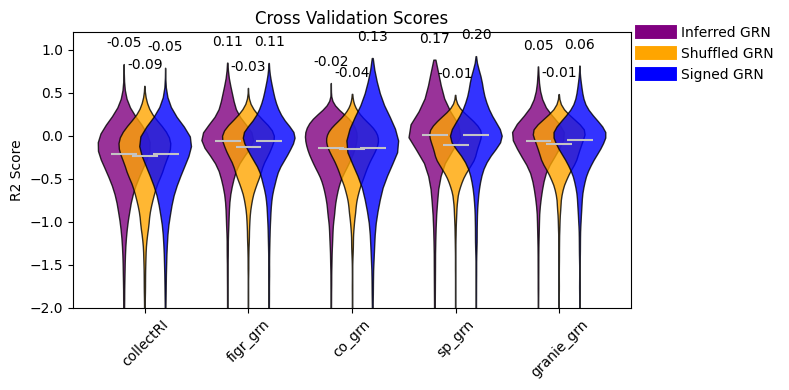

In [256]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4)) 
legend_colors = ['purple', 'orange', 'blue']
colors_map = {'purple': 'Inferred GRN', 'orange': 'Shuffled GRN', 'blue':'Signed GRN'}
offset = .2
handles = []  # To store legend handles
for i_plot, manipulate in enumerate([None, 'shuffled', 'signed']):
    # --- read the scores
    model_names = []
    mean_score_list = []
    gene_scores_list = []
    for grn_model in grn_models_dict.keys():
        file = f'{work_dir}/benchmark/scores/{n_tag}/{grn_model}_shuffled_{manipulate}.json'
        if not os.path.isfile(file):
            print(f'{file} doesnt exist')
            continue
        with open(file, 'r') as f:
            scores_dict = json.load(f)
            mean_score = scores_dict['mean_score']
            gene_scores = scores_dict['gene_scores']
        model_names.append(grn_model)
        mean_score_list.append(mean_score)
        gene_scores_list.append(gene_scores)
        # print(shuffled_flag, grn_model, np.mean(gene_scores))
    # plot 
    color_group = legend_colors[i_plot]
    x_ticks = range(len(model_names))
    x_positions = [xx + (offset*(i_plot-1)) for xx in x_ticks] 
    violin_parts = ax.violinplot(gene_scores_list, positions=x_positions, 
                                showmeans=False, 
                                showmedians=True, 
                                showextrema=False)
    
    for i, pc in enumerate(violin_parts['bodies']):
        color = color_group
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(.8)  # Ensuring the plot is fully opaque
        if colors_map[color] not in [h.get_label() for h in handles]:  # Avoid duplicate legend entries
            if color == 'white':
                continue
            handles.append(plt.Line2D([0], [0], color=color, linewidth=10, label=colors_map[color]))
    keys = ['cmaxes', 'cmins', 'cbars', 'cmedians']
    for key in keys:
        if key in violin_parts:
            violin_parts[key].set_edgecolor('#C4C4C4')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_title('Cross Validation Scores')
    ax.set_ylabel('R2 Score')
    ax.set_ylim([-2, 1.2])

    #-- annotate 
    y_positions = np.max(gene_scores_list, axis=1) + .2
    for ii, x_pos in enumerate(x_positions):
        y_pos = y_positions[ii]
        txt = f'{mean_score_list[ii]:.2f}'
        ax.text(x_pos, y_pos, txt, ha='center', color='black')
    
ax.legend(handles=handles, loc=(1.01,.8), frameon=False)
# # Correcting text annotations with offset adjustments

plt.tight_layout()
plt.show()

In [632]:
gene_scores_random = gene_scores


In [636]:

import scipy.stats as stats

# Generate your sample data (e.g., 'sample_data')
# Choose a theoretical distribution (e.g., 'norm' for normal distribution)
result = stats.kstest(gene_scores, gene_scores_random)

print(f"KS test statistic: {result.statistic}")
print(f"P-value: {result.pvalue}")



KS test statistic: 0.21888372093023256
P-value: 1.3355581369368384e-226


In [ ]:
# plt.hist(score_genes, bins=100)
mask = gene_scores > 0
score_genes_f = gene_scores[mask]
genes_f = df_train.columns[mask]

In [ ]:
hkgs_mask  = np.isin(genes_f, housekeeping_genes)

fig, axes = plt.subplots(1, 2, figsize=(8, 4)) 
ax = axes[0]
ax.hist(score_genes_f[hkgs_mask], label='Housekeeping', color='cyan', alpha=0.5)
ax.hist(score_genes_f[~hkgs_mask], label='Rest', color='grey', alpha=0.5)
ax.set_xlabel('R2 score')
ax.set_ylabel('Incident')
ax.legend()

# Regression analysis 

In [ ]:
cv_scheme = 'sm_name_10' # 'cell_type', 'sm_name', '10cv', 'sm_name_10', 'kn10', cell_type_plus
fraction_test_cell = 0.2


### Number of SVDs to summarize train data

In [ ]:
from sklearn.decomposition import TruncatedSVD, PCA

def func_svds(explained_variance_t=0.9): 
    """Determine number of SVDs to explain explained_variance_t"""
    n_components = 500
    reducer = TruncatedSVD(n_components=n_components, random_state=32) 
    reducer.fit(df_train)
    variance_explained = reducer.explained_variance_ratio_.cumsum()
    n_components = sum(variance_explained < explained_variance_t) + 1  # Number of components to capture 90% variance
    print(f"Number of components to retain {explained_variance_t} of the variance: {n_components}")
    return n_components
if True:
    n_components = func_svds()
    print(n_components)
    n_components = min([35, n_components])
    

## TF enrichment model

In [ ]:
def enrich_tfs_single(df_train_c, net):
    estimate, pvals = dc.run_ulm(
                df_train_c,
                net,
                # source='source',
                # target='target',
                # weight='weight',
                verbose=False
                )
    return estimate
def enrich_tfs_single_custom(df_train_c, net):
    from skranger import ensemble
    df = df_train_c.copy()
    net_genes = net.target.unique()
    shared_genes = np.intersect1d(net_genes, df.columns)

    net = net[net.target.isin(shared_genes)]
    y = df[shared_genes].values

    X = net.pivot(index='target', columns='source', values='weight').fillna(0)

    # regr_list = []
    # for i in tqdm.tqdm(range(y.shape[1])):
    #     regr = ensemble.RangerForestRegressor(n_estimators=100, n_jobs=10,
    #                                 seed=32, importance='impurity', oob_error=True)
    #     regr.fit(X, y[:, i])
    #     regr_list.append(regr)
    estimate = np.dot(y, X)
    
    return pd.DataFrame(estimate, index=df_train_c.index)

def enrich_tfs(df_train, net):
    "TF enrichment score cell specific grns"
    df_train_c = df_train.copy()
    df_train_c.index = df_train.index.map(lambda x: '@'.join(map(str, x))) # this is needed for enrichment analyisis
    if 'cell_type' in net:
        cell_type_index = df_train.index.get_level_values('cell_type')
        # EA for each cell type
        tf_act_stack = []
        for cell_type in net.cell_type.unique():
            if cell_type == 'agg_type':
                mask = cell_type_index.isin(agg_type)
            else:
                mask = cell_type_index==cell_type
            df_train_celltype = df_train_c[mask]

            net_celltype = net[net.cell_type==cell_type]
            tf_act = enrich_tfs_single(df_train_celltype, net_celltype)
            tf_act_stack.append(tf_act)
        tf_act_df = pd.concat(tf_act_stack).fillna(0)
        tf_act_df = tf_act_df.reindex(df_train_c.index)
            
    else:
        tf_act_df = enrich_tfs_single(df_train_c, net)
    return tf_act_df

# net = grn_models_all_dict['collectRI']
# tf_acts =  enrich_tfs(df_train, net)
# tf_acts.shape

### Clusters


In [ ]:
if False:
    tf_acts.index= df_train.index
    obs=tf_acts.index.to_frame().reset_index(drop=True)
    var=pd.DataFrame(index=tf_acts.columns)
    adata = anndata.AnnData(X=tf_acts.values, obs=obs , var=var)
    with warnings.catch_warnings():
        # sc.pp.normalize_per_cell(adata)
        sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=False)
        sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
        sc.tl.umap(adata)
        sc.pl.umap(adata, color=['cell_type'], frameon=False)
        sc.pl.pca(adata, color=['cell_type'], frameon=False)

### Number of SVDs to summarize TF scores

In [ ]:
if False:
    from sklearn.decomposition import PCA, TruncatedSVD

    def func_svds(df, net, explained_variance_t=0.9): 
        """Determine number of SVDs to explain 90% of varaince"""
        df_train_c = df.copy()
        tf_act = enrich_tfs(df_train_c, net)
        # print(tf_act.iloc[0:3,:5])
        n_components = min([500, tf_act.shape[1]])
        # reducer = TruncatedSVD(n_components=n_components, n_iter=10, random_state=32)
        reducer = PCA(n_components=n_components, random_state=32) 
        reducer.fit(tf_act)
        variance_explained = reducer.explained_variance_ratio_.cumsum()
        n_components = sum(variance_explained < explained_variance_t) + 1  # Number of components to capture 90% variance
        print(f"Number of components to retain {explained_variance_t} of the variance: {n_components}")
        return n_components
    if False:
        n_components_dict = {}
        for name, grn in grn_models_all_dict.items():
            print('----',name)
            if subset_genes:
                print('subsetting for gene')
                genes_mask = df_train.columns.isin(grn.target) # mask on genes
                df_train_tailored = df_train.loc[:, genes_mask] # subset training data for given genes
            else:
                df_train_tailored = df_train
            # print('number of target genes: ', len(df_train_tailored.columns))
            # print('tfs: ', grn.source.unique().shape)
            n_components_dict[name] = func_svds(df_train_tailored, grn)

In [ ]:
Ridge: 0.32
RF: 0.2942594697733679

0.26483145821910986

In [ ]:
aa

## geneRNI fit

In [ ]:
if True:
    from skranger import ensemble
    class generni:
        def __init__(self, net) -> None:
            df = df_train.copy()
            net_genes = net.target.unique()
            shared_genes = np.intersect1d(net_genes, df.columns)

            net = net[net.target.isin(shared_genes)]
            net = net[net.source.isin(df.columns)] # tfs should be as genes
            X_stack = []
            Y_stack = []

            for i, gene in enumerate(net.target.unique()):
                tfs = net[net.target== gene].source.unique()
                X_stack.append(df[tfs])
                Y_stack.append(df.iloc[:,i])

            self.X_stack = X_stack
            self.Y_stack = Y_stack

            print('number of genes: ', len(self.X_stack))

        def validate(self, mask_tr, mask_va):            
            oob_error_list = []
            Y_pred_stack = []
            Y_true_stack = []

            for i in tqdm.tqdm(range(len(self.Y_stack))):
                X = np.asarray(self.X_stack[i])
                Y =  np.asarray(self.Y_stack[i])
                X_tr, Y_tr = X[mask_tr,:], Y[mask_tr]
                X_va, Y_true = X[mask_va,:],Y[mask_va]
        
                # regr = ensemble.RangerForestRegressor(n_estimators=100, n_jobs=10,  seed=32, importance='impurity', oob_error=True)
                regr = Ridge(alpha=10, random_state=32)
                regr.fit(X_tr, Y_tr)
                Y_pred_stack.append(regr.predict(X_va))
                # print(regr.score(X_tr, Y_tr))
                Y_true_stack.append(Y_true)
                # oob_error_list.append(regr.ranger_forest_['prediction_error'])
            # oob_error = np.mean(oob_error_list)
            oob_error = None
            Y_pred = np.asarray(Y_pred_stack).T
            Y_true = np.asarray(Y_true_stack).T

            return oob_error, Y_pred, Y_true
        def CV(self):
            groups, group_assignments = cv_scheme_5f()
            # groups, group_assignments = cv_scheme_cell_type_two()

            Y_pred_stack = []
            Y_true_stack = []
            oob_error_stack = []

            for group in group_assignments:
                print('CV ', group)
                mask_va = groups==group
                mask_tr = ~mask_va
                oob_error, Y_pred, Y_true = self.validate(mask_tr, mask_va)
                oob_error_stack.append(oob_error)
                Y_pred_stack.append(Y_pred)
                Y_true_stack.append(Y_true)
                print(r2_score(Y_true, Y_pred, multioutput='variance_weighted'))
            return oob_error_stack, Y_pred_stack, Y_true_stack

    net = grn_models_all_dict['figr_grn_shuffled']
    model = generni(net)
    oob_error_list, Y_pred_stack, Y_true_stack = model.CV()
    y_pred_all = np.concatenate(Y_pred_stack, axis=0)
    y_true_all = np.concatenate(Y_true_stack, axis=0)
    r2score  = r2_score(y_true_all, y_pred_all, multioutput='variance_weighted')
    print(r2score)

## Regression models

### Encoder

In [ ]:
# from py_boost import GradientBoosting
random_state = 32
id_map = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/id_map.csv', index_col=0)

class model_encoder:
    def __init__(self, df_train, n_components_y=20, 
                    n_encode_tfs = 20,
                    te_params = dict(min_samples_leaf=20, smoothing=100),
                    grn_model=None
                    ):  
        # target df to encode
        self.n_encode_tfs = n_encode_tfs
        self.df_train = df_train
        self.grn_model = grn_model
        # regressor
        # self.emb_model = RandomForestRegressor(n_estimators=100, random_state=random_state)

        # self.emb_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=random_state))
        self.emb_model = Ridge(alpha=10, random_state=random_state)
        # self.emb_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
        self.reducer = TruncatedSVD(n_components=n_components_y, n_iter=12, random_state=random_state)
        self.Y = self.reducer.fit_transform(df_train)
        # encoder 
        self.enc = ce.TargetEncoder(**te_params) #[0, 0.05, 0.5, 0.1,0.9,10]
        # encode data
        self.emb_data = self.create_feature_space(self.df_train)
        self.determine_X()
        print(self.X.shape)
    def ohe(self, hot_encoding_features):
        for i, feature in tqdm.tqdm(enumerate(hot_encoding_features)):
            X_encoded = pd.get_dummies(self.df_train.reset_index()[feature], columns=[feature]).values
            if i == 0:
                X = X_encoded
                # X_submit = X_submit_encoded
            else:
                X = np.concatenate([X, X_encoded], axis = 1)
                # X_submit = np.concatenate([X_submit, X_submit_encoded], axis = 1)
        return X
    def target_encoding(self, feature_x, target_encoding_features):
        for i, feature in tqdm.tqdm(enumerate(target_encoding_features)):
            unique_names = self.df_train.index.get_level_values(feature).unique()
            n_components_enc = min([len(unique_names), feature_x.shape[1]])
            for i_target in tqdm.tqdm(range(n_components_enc)):
                if i_target == 0:
                    X_encoded = self.enc.fit_transform(self.df_train.reset_index()[feature], feature_x[:,i_target])
                    # X_submit_encoded = self.enc.transform(id_map.reset_index()[feature])
                else:
                    X_encoded_tmp = self.enc.fit_transform(self.df_train.reset_index()[feature], feature_x[:,i_target])
                    X_encoded = np.concatenate([X_encoded, X_encoded_tmp], axis = 1)
                    # X_encoded_tmp = self.enc.transform(id_map.reset_index()[feature])
                    # X_submit_encoded = np.concatenate([X_submit_encoded, X_encoded_tmp], axis = 1)
            if i==0:
                X = X_encoded
            else:
                X = np.concatenate([X, X_encoded], axis = 1)
        return X
    def determine_X(self):
        features = self.df_train.index.names
        feature_x = self.emb_data
        if self.grn_model is None:
            X = self.ohe(features)        
        else:
            X = self.target_encoding(feature_x, features)        
        self.X = X
    def create_feature_space(self, df_to_encode):
        if self.grn_model is not None:
            df_train_c = df_to_encode.copy()
            net = self.grn_model
            tf_act = enrich_tfs(df_train_c, net)
            if False: # to variable
                variances = tf_act.var()
                sorted_variances = variances.sort_values(ascending=False)
                top_tfs = sorted_variances.index.tolist()
                tf_act = tf_act[top_tfs].values
            elif True: # SVD
                n_components = min([tf_act.shape[1], 30])
                tf_act = TruncatedSVD(n_components=n_components, n_iter=12, random_state=random_state).fit_transform(tf_act)
            else: # keep the actual TF scores
                tf_act = tf_act.values
            return tf_act
    def validate(self, mask_tr, mask_va):
        X_tr, Y_tr = self.X[mask_tr,:], self.Y[mask_tr,:]
        X_va = self.X[mask_va,:]
        self.emb_model.fit(X_tr, Y_tr)
        y_pred = self.emb_model.predict(X_va)
        return self.reducer.inverse_transform(y_pred)
        # return self.emb_model.predict(X_va)
# net = grn_models_all_dict['figr_grn']
# mm = model_encoder(df_train, grn_model=net)
mm.emb_model = Ridge(alpha=10, random_state=random_state)
compute_cv(mm, df_train)


In [ ]:
cv_scheme = 'cell_type_plus'
if cv_scheme =='kn10':
    groups, group_assignments = cv_scheme_kn10()
elif cv_scheme=='sm_name': # cluster of sm_name
    groups, group_assignments = cv_scheme_sm_name()
elif cv_scheme=='sm_name_10': # cluster of sm_name
    groups, group_assignments = cv_scheme_sm_name_10()
elif cv_scheme=='cell_type': # one group for each trainig cell_type
    groups, group_assignments = cv_scheme_cell_type()
elif cv_scheme=='5cv':
    groups, group_assignments = cv_scheme_5f()
elif cv_scheme=='cell_type_plus':
    groups, group_assignments = cv_scheme_cell_type_plus()
elif cv_scheme=='cell_type_two':
    groups, group_assignments = cv_scheme_cell_type_two()
else:
    raise ValueError('define')
def compute_cv(model, df_train):
    y_true_list = []
    y_pred_list = []
    for group in tqdm.tqdm(group_assignments):
        mask_va = groups==group
        mask_tr = ~mask_va
        y_true = df_train[mask_va].values
        y_pred = model.validate(mask_tr, mask_va)
        if False:
            print('r2_score:', r2_score(y_true, y_pred, multioutput='variance_weighted'), 
                'mean_absolute_error: ', mean_absolute_error(y_true, y_pred))
        y_pred_list.append(y_pred)
        y_true_list.append(y_true)
    y_pred_all = np.concatenate(y_pred_list, axis=0)
    y_true_all = np.concatenate(y_true_list, axis=0)
    r2_score_overall = r2_score(y_true_all, y_pred_all, multioutput='variance_weighted')
    mean_absolute_error_overall = mean_absolute_error(y_true_all, y_pred_all)
    return r2_score_overall, mean_absolute_error_overall

In [ ]:
if False:
    import os
    # Optional: set the device to run
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    import joblib
    from sklearn.datasets import make_regression
    import numpy as np

    # simple case - just one class is used
    from py_boost import GradientBoosting, TLPredictor, TLCompiledPredictor
    from py_boost.cv import CrossValidation
    X, y = make_regression(150000, 100, n_targets=10, random_state=42)
    X_test, y_test = X[:50000], y[:50000]
    X, y = X[-50000:], y[-50000:]

    model = GradientBoosting('mse')

    model.fit(X, y)
    print(model.predict(X_test))
    model.fit(X, y)
    print(model.predict(X_test))


### Build

In [ ]:
enc_models = {}

In [ ]:
# create encoding models 
if True:
    for name, grn in grn_models_all_dict.items():
        print('----',name)
        enc_models[name] = model_encoder(df_train, grn_model=grn)
## add baseline model. 
if True:
    enc_models['baseline'] = model_encoder(df_train)


## Cross validation

In [ ]:

    
def cv_scheme_cell_type():
    cell_types = df_train.index.get_level_values('cell_type')
    train_cell_types = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']
    group_assignments = range(len(train_cell_types))
    group_dict = dict(zip(train_cell_types, group_assignments))
    groups = cell_types.map(group_dict)
    return groups, group_assignments
def cv_scheme_kn10():
    gene_expr_values = df_train.values
    num_clusters = 10 
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(gene_expr_values)
    groups = kmeans.labels_
    group_assignments = range(num_clusters)
    return groups, group_assignments
def cv_scheme_sm_name():
    sm_names = df_train.index.get_level_values('sm_name')
    unique_sm_names = sm_names.unique()
    group_assignments = range(len(unique_sm_names))
    group_dict = dict(zip(unique_sm_names, group_assignments))
    groups = sm_names.map(group_dict)
    return groups, group_assignments
def cv_scheme_sm_name_10():
    n = 10
    sm_names = df_train.index.get_level_values('sm_name')
    unique_sm_names = sm_names.unique().values
    group_assignments = range(n)
    np.random.shuffle(unique_sm_names)
    group_dict = {}
    for i, sm_name in enumerate(unique_sm_names):
        group_dict[sm_name] = i%n
    groups = sm_names.map(group_dict)
    return groups, group_assignments
def cv_scheme_cell_type_plus():
    np.random.seed(32)
    index = df_train.reset_index().index
    index_group = {}
    cv_fold = 0
    for test_cell in train_cell_types:
        mask_test_cell = df_train.index.get_level_values('cell_type')==test_cell
        index_test_cell = index[mask_test_cell]
        index_test_cell_size = index_test_cell.shape[0]
        for fraction in [fraction_test_cell]: # fraction of test cell to be included in train set. 0 equals cell_type cv
            test_size = int((1-fraction)*(index_test_cell_size))
            random_choice = np.random.choice(index_test_cell, size=test_size, replace=False)
            index_group = {**index_group, **{index:cv_fold for index in random_choice}}

            cv_fold+=1
    group_assignments = range(cv_fold)
    groups = index.map(index_group)
    return groups, group_assignments
def cv_scheme_cell_type_two():
    cell_types_cv = ['NK cells', 'T cells CD4+']
    np.random.seed(32)
    index = df_train.reset_index().index
    index_group = {}
    cv_fold = 0
    for test_cell in cell_types_cv:
        mask_test_cell = df_train.index.get_level_values('cell_type')==test_cell
        index_test_cell = index[mask_test_cell]
        index_test_cell_size = index_test_cell.shape[0]
        for fraction in [fraction_test_cell]: # fraction of test cell to be included in train set. 0 equals cell_type cv
            test_size = int((1-fraction)*(index_test_cell_size))
            random_choice = np.random.choice(index_test_cell, size=test_size, replace=False)
            index_group = {**index_group, **{index:cv_fold for index in random_choice}}

            cv_fold+=1
    group_assignments = range(cv_fold)
    groups = index.map(index_group)

    return groups, group_assignments
def cv_scheme_5f():
    num_groups = 5
    group_assignments = range(num_groups)
    group_size = len(df_train) // num_groups
    groups = np.repeat(np.arange(num_groups), group_size)
    if len(df_train) % num_groups != 0:
        groups = np.concatenate((groups, np.arange(len(df_train) % num_groups)))
    np.random.shuffle(groups)
    return groups, group_assignments


    
if cv_scheme =='kn10':
    groups, group_assignments = cv_scheme_kn10()
elif cv_scheme=='sm_name': # cluster of sm_name
    groups, group_assignments = cv_scheme_sm_name()
elif cv_scheme=='sm_name_10': # cluster of sm_name
    groups, group_assignments = cv_scheme_sm_name_10()
elif cv_scheme=='cell_type': # one group for each trainig cell_type
    groups, group_assignments = cv_scheme_cell_type()
elif cv_scheme=='5cv':
    groups, group_assignments = cv_scheme_5f()
elif cv_scheme=='cell_type_plus':
    groups, group_assignments = cv_scheme_cell_type_plus()
elif cv_scheme=='cell_type_two':
    groups, group_assignments = cv_scheme_cell_type_two()
else:
    raise ValueError('define')

def compute_cv(model, df_train):
    y_true_list = []
    y_pred_list = []
    for group in tqdm.tqdm(group_assignments):
        mask_va = groups==group
        mask_tr = ~mask_va
        y_true = df_train[mask_va].values
        y_pred = model.validate(mask_tr, mask_va)
        if False:
            print('r2_score:', r2_score(y_true, y_pred, multioutput='variance_weighted'), 
                'mean_absolute_error: ', mean_absolute_error(y_true, y_pred))
        y_pred_list.append(y_pred)
        y_true_list.append(y_true)
    y_pred_all = np.concatenate(y_pred_list, axis=0)
    y_true_all = np.concatenate(y_true_list, axis=0)
    r2_score_overall = r2_score(y_true_all, y_pred_all, multioutput='variance_weighted')
    mean_absolute_error_overall = mean_absolute_error(y_true_all, y_pred_all)
    return r2_score_overall, mean_absolute_error_overall

### actual run

In [ ]:
fresh_start = True
r2_scores_dict = {}
mse_dict = {}

for i, (name, model) in enumerate(enc_models.items()):
    print('\n')
    r2_score_overall, mean_absolute_error_overall = compute_cv(model, df_train)
    print('\n', name, r2_score_overall, mean_absolute_error_overall)

    r2_scores_dict[name] = r2_score_overall
    mse_dict[name] = mean_absolute_error_overall

In [ ]:
asas

### Results

In [ ]:
r2_scores_dict

In [ ]:
mse_dict

## Robustness to shuffle

In [ ]:
net = grn_models_all_dict['collectRI']
r2_stack = []
mae_stack = []
for i in range(10):
    net_shuffled = shuffle_grn(net)
    model = model_encoder(df_train=df_train, grn_model=net_shuffled)
    r2_score_overall, mean_absolute_error_overall = compute_cv(model, df_train)
    print(r2_score_overall)
    r2_stack.append(r2_score_overall)
    mae_stack.append(mean_absolute_error_overall)

In [ ]:
(r2_stack > r2_scores_dict['collectRI']).sum()

In [ ]:
asasa

In [ ]:
# r2_score(y_true_list[0].T, y_pred_list[0].T)
y_true = y_true_list[0]
y_pred = y_pred_list[0]
y_pred_all = np.concatenate(y_pred_list, axis=0)
y_true_all = np.concatenate(y_true_list, axis=0)
def custom_r2(y_true, y_pred):
    y_mean = y_true.mean(axis=0)
    # print((y_true - y_mean).shape)
    total_sum_of_squares = ((y_true - y_mean) ** 2).sum()
    sum_of_squares_of_residuals = ((y_true - y_pred) ** 2).sum()
    r2_score_case = 1 - (sum_of_squares_of_residuals / total_sum_of_squares)
    return r2_score_case
# custom_r2(y_true_all, y_pred_all)
r2_score(y_true, y_pred, multioutput='variance_weighted')


In [ ]:
# cross validation score
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), sharey=False)
data_dict = cv_scores_genes_dict

offset_amount = 0.4  # Control the offset amount for plots and text
legend_colors = ['purple', 'orange']
colors_map = {'purple': 'Inferred weight', 'orange': 'Inferred sign', 'white':''}
data_for_plot = []
labels_for_plot = []
positions = []
colors = []
current_position = 1
category_positions = {}  # Recalculating category positions
for key in data_dict.keys():
    
    data_for_plot.append(data_dict[key])
    category_label = surragate_names.get(key, key)
    if category_label not in category_positions:
        category_positions[category_label] = current_position
        labels_for_plot.append(category_label)
        current_position += 2
    positions.append(category_positions[category_label])
    colors.append('white')
violin_parts = ax.violinplot(data_for_plot, positions=positions, 
                             showmeans=False, 
                             showmedians=True, 
                             showextrema=False)
handles = []  # To store legend handles

for i, pc in enumerate(violin_parts['bodies']):
    color = colors[i]
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(.8)  # Ensuring the plot is fully opaque
    if colors_map[color] not in [h.get_label() for h in handles]:  # Avoid duplicate legend entries
        if color == 'white':
            continue
        handles.append(plt.Line2D([0], [0], color=color, linewidth=10, label=colors_map[color]))
keys = ['cmaxes', 'cmins', 'cbars', 'cmedians']
for key in keys:
    if key in violin_parts:
        violin_parts[key].set_edgecolor('#C4C4C4')

ax.set_xticks([pos for key, pos in category_positions.items()])
ax.set_xticklabels(labels_for_plot, rotation=45)
ax.set_title('Cross Validation Scores')
ax.set_ylabel('R2 Score')
ax.set_ylim([-.8, 1])
ax.legend(handles=handles, loc=(1.01,.8), frameon=False)
# Correcting text annotations with offset adjustments
for i, data in enumerate(data_for_plot):
    if len(data) == 0: continue  # Skip empty datasets
    mean_val = np.mean(data)
    text_pos = positions[i]
    plt.text(text_pos, max(data) + (0.1 * max(data)), f'{mean_val:.2f}', ha='center', color='black')
plt.tight_layout()
plt.show()

In [ ]:
[np.mean(cv_scores_genes_dict[name]) for name in cv_scores_genes_dict.keys()]
# cv_scores_genes_dict['baseline']

## Kaggle score
We can only submit if they are build on original data

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
os.environ['KAGGLE_USERNAME'] = 'jalilnourisa'
os.environ['KAGGLE_KEY'] = '63552f12403af36f40106e6821e80327'
api = KaggleApi()
api.authenticate()
# prefix = 'tfactivity_shuffled'  
prefix =  'trial2' 

gene_names = df_train.columns

os.makedirs(f'{work_dir}/submits/', exist_ok=True)

def format_y_submit(Y_submit):
    y_submit_df = pd.DataFrame(Y_submit, columns=gene_names)
    y_submit_df.index.name = 'id'
    y_submit_df = y_submit_df.round(5)
    return y_submit_df
def write_submit(Y_submit_df, file_name):
    Y_submit_df.to_csv(f'{work_dir}/submits/{file_name}.csv')
def submit(file_name):
    filename = f"../output/submits/{file_name}.csv"
    competition = "open-problems-single-cell-perturbations"
    api.competition_submit(file_name=filename, message=file_name, competition=competition)

for name, model in enc_models.items():
    if name in ['baseline', 'collectRI_sign']:
        continue
    file_name = f'{prefix}_{name}'
    print(name)
    y_submit = model.calculate_y_submit()
    y_submit_df = format_y_submit(y_submit)
    write_submit(y_submit_df, file_name)
    submit(file_name)
### kaggle scores
def get_kaggle_scores(prefix):
    submissions = api.competition_submissions("open-problems-single-cell-perturbations")
    kaggle_scores_dict = {}
    for submission in submissions:
        kaggle_scores_dict[submission.fileName.replace('.csv', '')] = [submission.publicScore,  submission.privateScore]
    kaggle_scores_dict = {key:values for key,values in kaggle_scores_dict.items() if (prefix in key)}
    kaggle_scores_df = pd.DataFrame(kaggle_scores_dict.values(), index=kaggle_scores_dict.keys(), columns=['public_test', 'private_test']).reset_index().rename(columns={'index':'grn_model'})
    kaggle_scores_df.grn_model = kaggle_scores_df.grn_model.str.replace(f'{prefix}_','')
    return kaggle_scores_df
get_kaggle_scores(prefix)

## Robustness analysis

### Random baseline

In [ ]:
# pool the predictions
y_submits = []
for name, enc_model in tqdm.tqdm(enc_models.items()):
    y_submits.append(enc_model.calculate_y_submit())
pool_ = np.concatenate([np.ndarray.flatten(y_submit) for y_submit in y_submits])


In [ ]:
y_submit_format = format_y_submit(y_submits[0])
y_submits_random = []
for i in range(100):
    y_submits_random.append(format_y_submit(np.random.choice(pool_, size=y_submit_format.shape)))

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
os.environ['KAGGLE_USERNAME'] = 'jalilnourisa'
os.environ['KAGGLE_KEY'] = '63552f12403af36f40106e6821e80327'
api = KaggleApi()
api.authenticate()
prefix = 'random'    

for i, y_submit_df in enumerate(y_submits_random):
    if i < 17:
        continue
    file_name = f'{prefix}_{i}'
    write_submit(y_submit_df, file_name)
    submit(file_name)

### Shuffle grn 

In [ ]:
prefix = 'shuffletest_100tf'
for name, grn in zip(['co_grn', 'figr_grn'], [co_grn, figr_grn]):
    file_name = f'{prefix}_{name}'
    print(file_name)
    y_submit = enc_model.calculate_y_submit()
    y_submit_df = format_y_submit(y_submit)
    write_submit(y_submit_df, file_name)
    submit(file_name)

    for i in range(20,100):
        grn_s = grn.copy()
        grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
        grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)

        dup_flags = grn_s[['source','target']].duplicated()
        grn_s = grn_s[~dup_flags].reset_index(drop=True)
        if grn_s.duplicated().sum()>0:
            raise ValueError('')
        #-- create the model
        sm_name_svd_n = 100
        celltype_svd_n = 100

        enc_model = model_encoder(df_main_reg, grn_model=grn_s, shares={
                                            'sm_name':{'tf_x':sm_name_svd_n},
                                            'cell_type': {'tf_x':celltype_svd_n}
                                            })
        file_name = f'{prefix}_{name}_{i}'
        print(file_name)
        y_submit = enc_model.calculate_y_submit()
        y_submit_df = format_y_submit(y_submit)
        write_submit(y_submit_df, file_name)
        submit(file_name)

In [ ]:
df = get_kaggle_scores(prefix)
real  = df[df.grn_model=='figr_grn']
rest = df[df.grn_model!='figr_grn']
for score in ['public_test', 'private_test']:
    # print(rest[score].astype(float).mean())
    print(real[score].mean(), rest[score].astype(float).mean())

# df = get_kaggle_scores(prefix)
real  = df[df.grn_model=='co_grn']
rest = df[df.grn_model!='co_grn']
for score in ['public_test', 'private_test']:
    # print(rest[score].astype(float).mean())
    print(real[score].mean(), rest[score].astype(float).mean())

In [ ]:
from scipy import stats
real  = df[df.grn_model=='co_grn']
rest = df[df.grn_model!='co_grn']
for score in ['public_test', 'private_test']:
    # print(rest[score].astype(float).mean())
    print(real[score].mean(), rest[score].astype(float).mean())
    # Sample data: Replace 'sample_data' with your sample data array
    sample_data = rest[score].astype(float).values

    # # The single value you want to compare the sample against
    population_mean = real[score].astype(float).values[0]

    # # Perform the one-sample t-test
    print(population_mean)
    t_stat, p_value = stats.ttest_1samp(sample_data, population_mean)
    print(p_value)

In [ ]:
np.mean(cv_scores)

## Plot 

In [ ]:
kaggle_scores_df = pd.read_csv(f'{work_dir}/benchmark/kaggle_scores_df.csv', index_col=0)
with open(f'{work_dir}/benchmark/CV/cv_scores_genes_dict_{original_data}_{only_sig_de}_{subset_genes}.json', 'r') as file:
    cv_scores_genes_dict = json.load(file)
    cv_scores_genes_dict = {key:np.asarray(values) for key,values in cv_scores_genes_dict.items()}

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

# n components for TF acts
ax = axes[0]
data_dict = n_components_dict
normal_data = {k: v for k, v in data_dict.items() if "_sign" not in k}
signed_data = {k.replace("_sign", ""): v for k, v in data_dict.items() if "_sign" in k}
labels = list(normal_data.keys())
normal_values = [normal_data[label] for label in labels]
signed_values = [0 if (label=='collectRI') else signed_data[label] for label in labels ]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
rects1 = ax.bar(x - width/2, normal_values, width, label='Inferred weight')
rects2 = ax.bar(x + width/2, signed_values, width, label='Inferred sign')
ax.set_ylabel('Number of PCs')
ax.set_title('PCA of TF activity')
ax.set_xticks(x)
ax.set_xticklabels([surragate_names[label] for label in labels], rotation=45)
ax.legend()
# public and private test scores 
axes_ = axes[1:3]
def categorize_model(row):
    if '_sign' in row['grn_model']:
        return 'Inferred sign'
    else:
        return 'Inferred weight'
kaggle_scores_df['model_group'] = kaggle_scores_df['grn_model'].str.replace('_sign', '', regex=False)
kaggle_scores_df['category'] = kaggle_scores_df.apply(categorize_model, axis=1)
kaggle_scores_df['public_test'] = pd.to_numeric(kaggle_scores_df['public_test'], errors='coerce')
kaggle_scores_df['private_test'] = pd.to_numeric(kaggle_scores_df['private_test'], errors='coerce')
for i, score_type in enumerate(['public_test', 'private_test']):
    kaggle_scores_df[score_type] = kaggle_scores_df[score_type]/max(kaggle_scores_df[score_type])
    ax = axes_[i]
    sns.barplot(x='model_group', y=score_type, 
                hue='category', 
                data=kaggle_scores_df, 
                ax=ax, 
                dodge=True,
                )
    ax.set_title(f'{score_type.replace("_", " ").capitalize()}')
    ax.set_xticklabels([surragate_names[label] for label in kaggle_scores_df.model_group.unique()])
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('Error value (MRRMSE)')
    ax.legend(title='', loc='upper left', bbox_to_anchor=(.45, 1))
    ax.set_ylim(0.7, 1.05)  # Adjust y-axis range

plt.tight_layout()


In [ ]:
# cross validation score
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), sharey=False)
data_dict = cv_scores_genes_dict

offset_amount = 0.4  # Control the offset amount for plots and text
legend_colors = ['purple', 'orange']
colors_map = {'purple': 'Inferred weight', 'orange': 'Inferred sign', 'white':''}
data_for_plot = []
labels_for_plot = []
positions = []
colors = []
current_position = 1
category_positions = {}  # Recalculating category positions
for key in data_dict.keys():
    if "sign" not in key and (key + "_sign") in data_dict:
        original_data_ = data_dict[key]
        signed_data = data_dict[key + "_sign"]
        data_for_plot += [original_data_, signed_data]
        category_label = surragate_names.get(key, key)
        if category_label not in category_positions:
            category_positions[category_label] = current_position
            labels_for_plot.append(category_label)
            current_position += 2  # Adjust for the next category, including space for offset
        # Adjust positions with the offset
        positions += [category_positions[category_label] - offset_amount, category_positions[category_label] + offset_amount]
        colors += legend_colors
    elif "baseline" in key or "collectRI" in key:
        data_for_plot.append(data_dict[key])
        category_label = surragate_names.get(key, key)
        if category_label not in category_positions:
            category_positions[category_label] = current_position
            labels_for_plot.append(category_label)
            current_position += 2
        positions.append(category_positions[category_label])
        colors.append('white')
violin_parts = ax.violinplot(data_for_plot, positions=positions, 
                             showmeans=False, 
                             showmedians=True, 
                             showextrema=False)
handles = []  # To store legend handles

for i, pc in enumerate(violin_parts['bodies']):
    color = colors[i]
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(.8)  # Ensuring the plot is fully opaque
    if colors_map[color] not in [h.get_label() for h in handles]:  # Avoid duplicate legend entries
        if color == 'white':
            continue
        handles.append(plt.Line2D([0], [0], color=color, linewidth=10, label=colors_map[color]))
keys = ['cmaxes', 'cmins', 'cbars', 'cmedians']
for key in keys:
    if key in violin_parts:
        violin_parts[key].set_edgecolor('#C4C4C4')

ax.set_xticks([pos for key, pos in category_positions.items()])
ax.set_xticklabels(labels_for_plot, rotation=45)
ax.set_title('Cross Validation Scores')
ax.set_ylabel('R2 Score')
ax.set_ylim([-.8, 1])
ax.legend(handles=handles, loc=(1.01,.8), frameon=False)
# Correcting text annotations with offset adjustments
for i, data in enumerate(data_for_plot):
    if len(data) == 0: continue  # Skip empty datasets
    mean_val = np.mean(data)
    text_pos = positions[i]
    plt.text(text_pos, max(data) + (0.1 * max(data)), f'{mean_val:.2f}', ha='center', color='black')
plt.tight_layout()
plt.show()


In [ ]:
violin_parts.keys()